# Libraries & Custom functions

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def binary_cross_entropy(y_true, y_hat):
    return -1 * (y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))


def forward_pass(x, t, h, h_0, v, b, y_true, w):
    h_value = lambda t: h_0 if t == 1 else h[0]
    h[t - 1] = torch.matmul(w.T, x[t - 1]) + v * h_value(t) + b
    h[t - 1] = F.sigmoid(h[t - 1])
    y_hat = h[t - 1]
    # Compute the loss
    loss = binary_cross_entropy(y_true[t - 1], y_hat)
    
    return y_hat, loss


# Implement the backward pass of a RNN
def backward_pass(x, t, h_0, h, y_true, y_hat):
    # Compute the gradient of the loss with respect to y_hat
    grad_y_hat = -1 * (y_true[t - 1] / y_hat - (1 - y_true[t - 1]) / (1 - y_hat))
    # Compute the gradient of the loss with respect to h
    grad_h = grad_y_hat * (y_hat * (1 - y_hat))
    # Compute the gradient of the loss with respect to w
    grad_w = grad_h * x[t - 1]
    # Compute the gradient of the loss with respect to b
    grad_b = grad_h * 1
    # Compute the gradient of the loss with respect to v
    h_value = lambda t: h_0 if t == 1 else h[0]
    grad_v = grad_h * h_value(t)

    return grad_w, grad_b, grad_v


def update_parameters(w, grad_w, b, grad_b, v, grad_v, learning_rate):
    w_new = w - learning_rate * grad_w
    b_new = b - learning_rate * grad_b
    v_new = v - learning_rate * grad_v
    return w_new, b_new, v_new


# Implement a simple RNN that only updates the weights
def SimpleRNN(x, y_true, w, v, b, learning_rate = 0.1, epochs = 1000):
    # Initialize hidden state
    h = torch.zeros(2)
    cost_values = []
    for i in range(epochs):
        loss_values = []
        for t in range(1, 3):
            h_0 = 0
            # Forward pass
            y_hat, loss = forward_pass(x = x, 
                                       t = t, 
                                       h = h, 
                                       h_0 = h_0, 
                                       v = v, 
                                       b = b, 
                                       y_true = y_true, 
                                       w = w)
            # Compute loss
            loss = binary_cross_entropy(y_true[t - 1], y_hat)
            # Backward pass
            grad_w, grad_b, grad_v = backward_pass(x = x, 
                                                   t = t, 
                                                   h_0 = h_0,
                                                   h = h,
                                                   y_true = y_true, 
                                                   y_hat = y_hat)
            # Update weights and bias
            w, b, v = update_parameters(w, grad_w, b, grad_b, v, grad_v, learning_rate)
            loss_values.append(loss)

        # Store the loss of the last batch of the epoch    
        cost_values.append(torch.mean(torch.stack(loss_values)))
        # Print progress
        if i % 20 == 0:
            print("Epoch {}: cost = {}".format(i, cost_values[-1]))
    return cost_values, w, b, v


def PlotCost(cost_values):
    plt.plot(cost_values)
    plt.title('SimpleRNN training results with SGD (unit batch size)')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.show()

# Exercise 2, a)

In [3]:
x = torch.tensor([[0.3, -0.2], 
                  [0.1, 0.1]])
w = torch.tensor([1.0, -1.0])
v = -1
b = 0
h = torch.tensor([0.0, 0.0])
h_0 = torch.tensor([0.0])
y_true = torch.tensor([1, 0])

## i)

In [4]:
y_hat, loss = forward_pass(x = x, t = 1, h = h, h_0 = h_0, v = v, b = b, y_true = y_true, w = w)

# print the results
print("The predicted value is y_hat = {}".format(y_hat))
print("The loss is {}".format(loss))

The predicted value is y_hat = 0.622459352016449
The loss is 0.4740769565105438


## ii)

In [5]:
grad_w, grad_b, grad_v = backward_pass(x = x, t = 1, h_0 = h_0, h = h, y_true = y_true, y_hat = y_hat)

learning_rate = 0.1
w_new, b_new, v_new = update_parameters(w, grad_w, b, grad_b, v, grad_v, learning_rate)

# print the results
print("The new weight vector is {}".format(w_new))

The new weight vector is tensor([ 1.0113, -1.0076])


## Extra (improving the RNN's cost with more epochs)

In [6]:
costs, w, b, v = SimpleRNN(x, y_true, w, v, b, learning_rate = 0.5, epochs = 500)

Epoch 0: cost = 0.48722559213638306
Epoch 20: cost = 0.20762427151203156
Epoch 40: cost = 0.11060062050819397
Epoch 60: cost = 0.0727277547121048
Epoch 80: cost = 0.05372672900557518
Epoch 100: cost = 0.04248959571123123
Epoch 120: cost = 0.03510754555463791
Epoch 140: cost = 0.029899876564741135
Epoch 160: cost = 0.02603379637002945
Epoch 180: cost = 0.02305181324481964
Epoch 200: cost = 0.020682547241449356
Epoch 220: cost = 0.018755130469799042
Epoch 240: cost = 0.017156679183244705
Epoch 260: cost = 0.01580970361828804
Epoch 280: cost = 0.014659170061349869
Epoch 300: cost = 0.013665089383721352
Epoch 320: cost = 0.012797530740499496
Epoch 340: cost = 0.012033823877573013
Epoch 360: cost = 0.011356324888765812
Epoch 380: cost = 0.010751292109489441
Epoch 400: cost = 0.010207563638687134
Epoch 420: cost = 0.009716369211673737
Epoch 440: cost = 0.009270377457141876
Epoch 460: cost = 0.00886365957558155
Epoch 480: cost = 0.008491234853863716


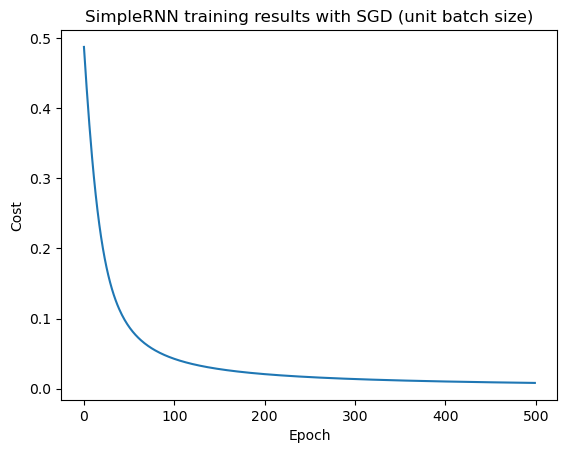

The final weight vector is:     tensor([ 3.4531, -3.9772])
The final bias vector is:       2.809420347213745
The final scalar v vector is:   -7.839944362640381


In [7]:
PlotCost(costs)
print("The final weight vector is:     {}".format(w))
print("The final bias vector is:       {}".format(b))
print("The final scalar v vector is:   {}".format(v))